# Elo Merchant Category Recommendation - LynxKite preprocessor
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import math
import warnings
import datetime
import statistics
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Input data preparation
### Train & test data

In [4]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv", index_col='card_id')
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.8% reduction)
Number of historical transactions: 29,112,361
Wall time: 5min 28s


In [5]:
%%time
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv", index_col='card_id')
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
Number of new transactions: 1,963,031
Wall time: 6.56 s


In [6]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [7]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'Y': 1, 'N': 0})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [8]:
df_hist_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_4e6213e9bc,1,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,15,25,6,2
C_ID_4e6213e9bc,1,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,12,28,5,3
C_ID_4e6213e9bc,1,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,22,32,2,3


In [9]:
df_new_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_415bb3a509,1,107,0,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19,2018,3,11,14,10,6,1
C_ID_415bb3a509,1,140,0,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19,2018,3,19,18,12,0,1
C_ID_415bb3a509,1,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14,2018,4,26,14,17,3,2


If you want to save transactions connecting specific customer vertices, use the block below.

In [ ]:
cols = ('C_ID_3b297b98b2', 'C_ID_0dcb7bedcf', 'C_ID_4dcdeb27e4', 'C_ID_96bb9e0008', 'C_ID_c0b9cac086', 'C_ID_310be2af53', 'C_ID_8ead828e10', 'C_ID_21117571cf', 'C_ID_d5962d5324', 'C_ID_8fc635b8cc', 'C_ID_a864f93aaa', 'C_ID_67ed87cfd8', 'C_ID_b3dcdca2bf', 'C_ID_0d6b8c2d0f', 'C_ID_de92f6f007', 'C_ID_34a8dbcd67', 'C_ID_0e4bbeaef2', 'C_ID_dc9c5fe1b8', 'C_ID_ddda020c19', 'C_ID_5037ff576e', 'C_ID_59adbef773', 'C_ID_fa73b85d9f', 'C_ID_6e38ce95e5', 'C_ID_54ba74790a', 'C_ID_5d8793d8a3', 'C_ID_a3b8ec250a', 'C_ID_0382b662f4', 'C_ID_0ac3bdba13', 'C_ID_55aa6d6d5e', 'C_ID_094a0016ee', 'C_ID_8b7650c51a', 'C_ID_8530ef3114', 'C_ID_a6c19c14c2', 'C_ID_0d966d5bb3', 'C_ID_1a16072149', 'C_ID_0e171c1b48', 'C_ID_3b54c9951f', 'C_ID_db71047141', 'C_ID_ae8deed850', 'C_ID_2f6751b08c', 'C_ID_e3eaaf0ce2', 'C_ID_9d5614d4d4', 'C_ID_ac54812859', 'C_ID_ecae7401f1', 'C_ID_5e558b8771', 'C_ID_bf8f463e73', 'C_ID_466977c3a6', 'C_ID_3fff3df454', 'C_ID_6ea1a4947f', 'C_ID_3249a3e3c3', 'C_ID_b7873760fe', 'C_ID_5b98ebe338', 'C_ID_8c0201c7d8', 'C_ID_7d87b2c9b0', 'C_ID_5481d0ce7b', 'C_ID_abd541d01e', 'C_ID_082020e48f', 'C_ID_324cc02fa3', 'C_ID_d6f97e5780', 'C_ID_99c391a674', 'C_ID_269d5da08d', 'C_ID_542f1fa442', 'C_ID_06b77830e2', 'C_ID_f0f1b0e44b', 'C_ID_cd401594f8', 'C_ID_532c46e82a', 'C_ID_963f024506', 'C_ID_bfffcd4064', 'C_ID_575f3c7299', 'C_ID_3acbfc844a', 'C_ID_e19bb972b7', 'C_ID_d793cf0bdf', 'C_ID_d3ec4a9f31', 'C_ID_5ef4e703f7', 'C_ID_c0fdcc9bb6', 'C_ID_1626d68d07', 'C_ID_b20540b62d', 'C_ID_e109e07eb2', 'C_ID_28fa6e1b95', 'C_ID_4438374542', 'C_ID_3917d75318', 'C_ID_fe4dd0d9dd', 'C_ID_a0a8f2a2dd', 'C_ID_a980c15f58', 'C_ID_eb250c57f5', 'C_ID_8365e2648a', 'C_ID_c95cd104c1', 'C_ID_6107f3d6c2', 'C_ID_661830c108', 'C_ID_89f75e7d82', 'C_ID_ae9a186307', 'C_ID_1fba7e1cfa', 'C_ID_d3a66157a0', 'C_ID_27de525a35', 'C_ID_a0fb489ce1', 'C_ID_ae86f7d5fb', 'C_ID_66f025e164', 'C_ID_f52b7b5563', 'C_ID_9085892d9d', 'C_ID_6c42fcb585', 'C_ID_7ce2c0198d', 'C_ID_4f68cca7a0', 'C_ID_a959a584cc', 'C_ID_422117ed25', 'C_ID_d26b4291db', 'C_ID_4a1d9765f8', 'C_ID_de30fec963', 'C_ID_23518d5fe7', 'C_ID_e834f752c5', 'C_ID_98abe8365a', 'C_ID_396885e977', 'C_ID_19d5c8812e', 'C_ID_fcf602b303', 'C_ID_65188857e6', 'C_ID_8c4310aa0b', 'C_ID_16ebae3306', 'C_ID_9e6b3e491a', 'C_ID_7e8f7e2ff2', 'C_ID_3df86e0089', 'C_ID_2f6f120cf8', 'C_ID_0998bf9e51', 'C_ID_02cc9ba024', 'C_ID_b45d4d37b1', 'C_ID_b271e7ab60', 'C_ID_01904d743d', 'C_ID_a7d3313624', 'C_ID_9861d0fa05', 'C_ID_37cd39cd15', 'C_ID_206fcaf22f', 'C_ID_ca09e9cea5', 'C_ID_57c74056eb', 'C_ID_ae1363307b', 'C_ID_1e5197c60a', 'C_ID_d41d4f60ef', 'C_ID_1f04b26739', 'C_ID_2b69ff3d45', 'C_ID_a1b71153bd', 'C_ID_5f1aa8ad77', 'C_ID_d244d8976d', 'C_ID_fc8e41b9cf', 'C_ID_375af5c403', 'C_ID_6f8d56d71a', 'C_ID_b762734ff1', 'C_ID_4de2220387', 'C_ID_9ccb22f5ba', 'C_ID_a85af7105b', 'C_ID_ca434fdc9a', 'C_ID_d89ed6f903', 'C_ID_2baa9db487', 'C_ID_cf615002dd', 'C_ID_c14a40541e', 'C_ID_635cb0727f', 'C_ID_f58ef7a582', 'C_ID_3e00ef3f82', 'C_ID_b1ce08a6d0', 'C_ID_87d0d2fd99', 'C_ID_225a70c9da', 'C_ID_434428e462', 'C_ID_f2e160883a', 'C_ID_fd5d1d036a', 'C_ID_d8ab1b33a2', 'C_ID_d931f87212', 'C_ID_93d201f55f', 'C_ID_5f908016f7', 'C_ID_5e5555f2ea', 'C_ID_afbb8e417e', 'C_ID_58cde062ed', 'C_ID_95077ee141', 'C_ID_c56da88dff', 'C_ID_c9f2b024e9', 'C_ID_149d46d5d6', 'C_ID_3c8e3894db', 'C_ID_5c00f333c0', 'C_ID_7708547f5b', 'C_ID_59b56d1e88', 'C_ID_fe97da1633', 'C_ID_f531b08078', 'C_ID_896f0e6096', 'C_ID_4bed29d75c', 'C_ID_393b2ef990', 'C_ID_c8fb63a431', 'C_ID_6356c35053', 'C_ID_dcd74bca0d', 'C_ID_f3df5d55f9', 'C_ID_b22d445d78', 'C_ID_b86ad6f26b', 'C_ID_bdf550bccd', 'C_ID_63c433bd94', 'C_ID_9ac0d2f776', 'C_ID_d7c4f585a0', 'C_ID_855fbbcbe0', 'C_ID_651c203a79', 'C_ID_1170a4101e', 'C_ID_b8a0610439', 'C_ID_01b098ff01', 'C_ID_e375f96772', 'C_ID_d1e9049805', 'C_ID_f466e63724', 'C_ID_565eea411b', 'C_ID_4edae7c94f', 'C_ID_de61f65ad9', 'C_ID_9c199928d9', 'C_ID_c216431929', 'C_ID_577adf384e', 'C_ID_deda0cca28', 'C_ID_adafc22926', 'C_ID_fb0366b9bf', 'C_ID_36742bf16a', 'C_ID_9340bd3efb', 'C_ID_fe2cf74a3c', 'C_ID_4e8ff74a06', 'C_ID_600545406a', 'C_ID_59604814a9', 'C_ID_1950177218', 'C_ID_a2297a992c', 'C_ID_2addfdb32f', 'C_ID_61f0bd6ecf', 'C_ID_3951902b7d', 'C_ID_7133b0dba0', 'C_ID_9f21a05b07', 'C_ID_ea299331ff', 'C_ID_4588654788', 'C_ID_74f3f3b63f', 'C_ID_30ec43c662', 'C_ID_3da75e85ea', 'C_ID_5fcd403807', 'C_ID_af912c5938', 'C_ID_5eef3384f5', 'C_ID_41b88ec506', 'C_ID_99f00fd8b4', 'C_ID_536bff298a', 'C_ID_d0a8c728be', 'C_ID_8d2a9e9f02', 'C_ID_bbde7637a1', 'C_ID_12e8350931', 'C_ID_3173592630', 'C_ID_cf58d5be10', 'C_ID_c7c14d34b0', 'C_ID_d2e70e9653', 'C_ID_64b849f050', 'C_ID_093d35c85b', 'C_ID_618fea3c1c', 'C_ID_a22de71ac8', 'C_ID_9f6ab4a101', 'C_ID_954eebf6b2', 'C_ID_62a64f942c', 'C_ID_6318b13586', 'C_ID_ce026bf60b', 'C_ID_87fa00165a', 'C_ID_d3b06b0fe2', 'C_ID_e6c5c7f7a7', 'C_ID_c3ebae4cfb', 'C_ID_f8598ef051', 'C_ID_94f2c85d55', 'C_ID_2391482aa2', 'C_ID_b68861894d', 'C_ID_69d6ea6a2d', 'C_ID_9311c9e1d2', 'C_ID_d0882a3bce', 'C_ID_4515537c55', 'C_ID_83d49f36ff', 'C_ID_f8f16746a1', 'C_ID_1f24dc4823', 'C_ID_12898d9f0c', 'C_ID_a9bc1c6200', 'C_ID_454bf27987', 'C_ID_1da0ce93b5', 'C_ID_1a4fb91bf1', 'C_ID_6d31cab489', 'C_ID_9ff71414ce', 'C_ID_198914cf94', 'C_ID_03d3f6c6f4', 'C_ID_261c245e65', 'C_ID_398122d796', 'C_ID_9deaeaf200', 'C_ID_5786ec9f45', 'C_ID_b448b1df4b', 'C_ID_460bb1bafa', 'C_ID_25236b70f6', 'C_ID_7332ad5a4a', 'C_ID_e5f5fcf6e7', 'C_ID_12b7811978', 'C_ID_8134216e2d', 'C_ID_149071be4f', 'C_ID_f894a3884a', 'C_ID_622ed23564', 'C_ID_e4f9fdda44', 'C_ID_c504d73c6f', 'C_ID_1964c39b55')

df_hist_trans.loc[cols,:].to_csv('input/trans_hist_trimmed.csv')
print('{:,} rows were saved.'.format(df_hist_trans.loc[cols,:].shape[0]))

In [12]:
%%time
df_hist_trans.to_csv('preprocessed/trans_hist.csv')
df_new_trans.to_csv('preprocessed/trans_new.csv')

Wall time: 12min 11s


#### Grouping

In [24]:
df_hist_gb_card_id = df_hist_trans.groupby("card_id").size().reset_index().set_index('card_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [25]:
df_hist_gb_card_id[:3]

,number_of_transactions
card_id,
C_ID_00007093c1,149
C_ID_0001238066,123
C_ID_0001506ef0,66


In [26]:
df_hist_gb_merchant_id = df_hist_trans.groupby("merchant_id").size().reset_index().set_index('merchant_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [27]:
df_hist_gb_merchant_id[:3]

,number_of_transactions
merchant_id,
M_ID_000025127f,9
M_ID_0000699140,57
M_ID_00006a5552,1


### Train and test data

In [28]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"], index_col="card_id")
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 5 features in train set.


In [29]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"], index_col="card_id")
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 4 features in test set.


In [30]:
df_train[:3]

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820312
C_ID_3d0044924f,2017-01-01,4,1,0,0.392822
C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988


In [31]:
df_test[:3]

,first_active_month,feature_1,feature_2,feature_3
card_id,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1
C_ID_130fd0cbdd,2017-01-01,2,3,0
C_ID_b709037bc5,2017-08-01,5,1,1


In [32]:
q1_tr = int(df_train['target'].count()/4)
q3_tr = int(3*df_train['target'].count()/4)

df_train.sort_values(by='target', inplace=True, na_position='last')

print('Range of the target in the training set: {} - {}'.format(df_train['target'].min(), df_train['target'].max()))
print('Interquartile range of target in the training set: {} - {}'.format(df_train['target'].iloc[q1_tr], df_train['target'].iloc[q3_tr]))

Range of the target in the training set: -33.21875 - 17.96875
Interquartile range of target in the training set: -0.88330078125 - 0.765625


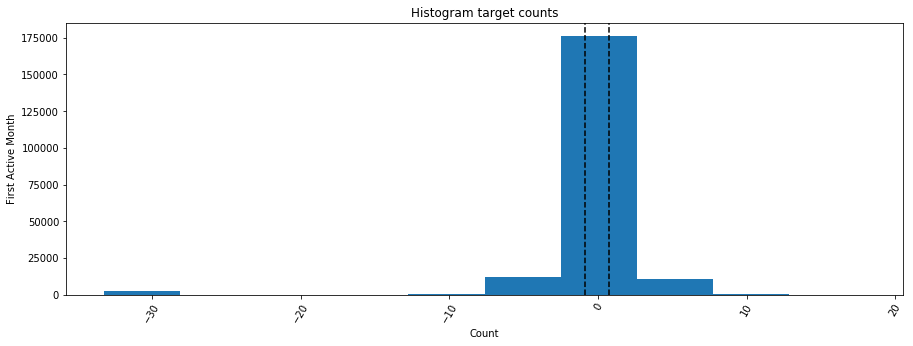

In [33]:
plt.figure(figsize=(15, 5))
plt.hist(df_train['target'].values)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('First Active Month')
plt.axvline(df_train['target'].iloc[q1_tr], color="k", linestyle="--")
plt.axvline(df_train['target'].iloc[q3_tr], color="k", linestyle="--")
plt.show()

In [34]:
print('According to Rice\'s rule, the number of bins is {:.0f} (for the whole set)'.format(math.sqrt(df_train.shape[0])*2))
print('According to Rice\'s rule, the number of bins is {:.0f} (without the outliers)'.format(math.sqrt(df_train[df_train['target'] > -30].shape[0])*2))

According to Rice's rule, the number of bins is 899 (for the whole set)
According to Rice's rule, the number of bins is 894 (without the outliers)


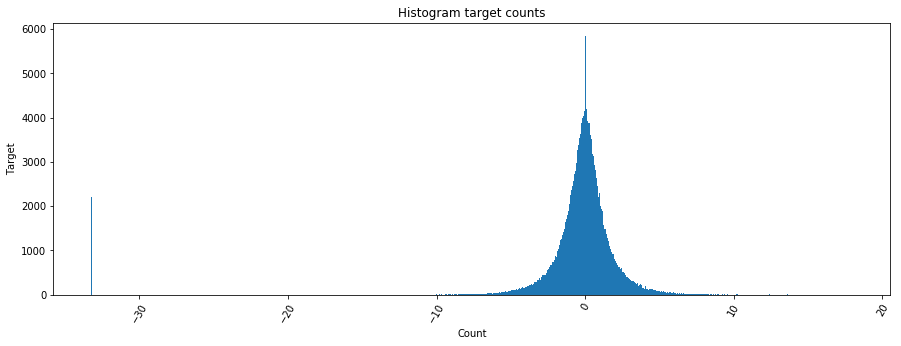

In [35]:
plt.figure(figsize=(15, 5))
plt.hist(df_train['target'].values, bins=899)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Target')
plt.show()

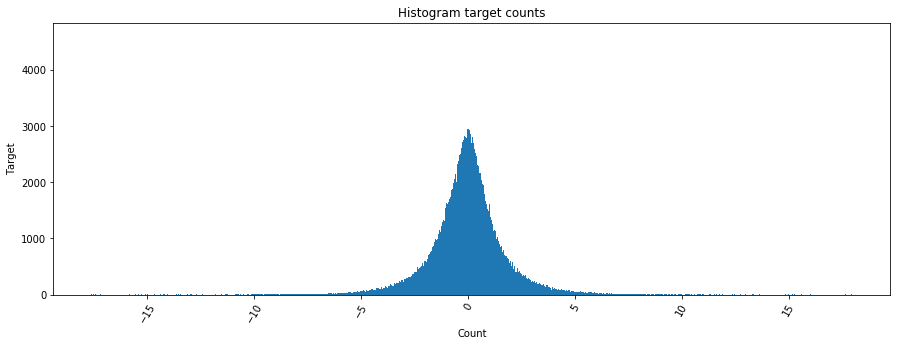

In [36]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -30]['target'].values, bins=894)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Target')
plt.show()

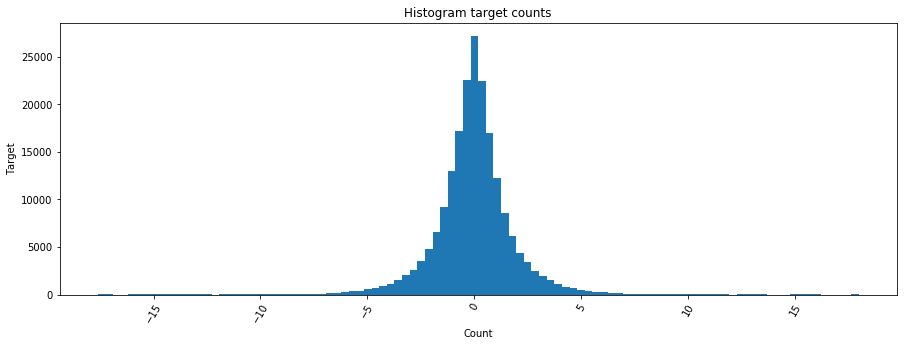

In [37]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -30]['target'].values, bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Target')
plt.show()

In [38]:
range = math.fabs(df_train[df_train['target'] > -30]['target'].min()) + df_train[df_train['target'] > -30]['target'].max()
print('The range of the training set without the outliers is {}'.format(range))

The range of the training set without the outliers is 35.578125


In [39]:
print('Minimum value without outliers: {}, width of bin: {}'.format(df_train[df_train['target'] > -30]['target'].min(), range/100))

Minimum value without outliers: -17.609375, width of bin: 0.35578125


In [40]:
def create_bin(value, min_value, bin_width, cutoff_value=-20):
    return np.where(value > min_value, ((value - min_value)/bin_width).astype(int), 0)

In [41]:
min_value = df_train[df_train['target'] > -30]['target'].min()
bin_width = range/100

df_train['target_bin'] = create_bin(df_train['target'], min_value, bin_width)

In [42]:
df_train[:3]

,first_active_month,feature_1,feature_2,feature_3,target,target_bin
card_id,,,,,,
C_ID_26891f7d19,2017-06-01,3,2,1,-33.21875,0
C_ID_5813c755d9,2014-10-01,5,1,1,-33.21875,0
C_ID_213342324e,2015-08-01,3,3,1,-33.21875,0


In [43]:
train_first = df_train['first_active_month'].min()
train_last = df_train['first_active_month'].max()

print("The first_active_month attribute in the train set is ranging between {0}-{1:02}-{2:02} and {3}-{4:02}-{5:02}.".format(train_first.year, train_first.month, train_first.day, train_last.year, train_last.month, train_last.day))

The first_active_month attribute in the train set is ranging between 2011-11-01 and 2018-02-01.


In [44]:
test_first = df_test['first_active_month'].min()
test_last = df_test['first_active_month'].max()

print("The first_active_month attribute in the test set is ranging between {0}-{1:02}-{2:02} and {3}-{4:02}-{5:02}.".format(test_first.year, test_first.month, test_first.day, test_last.year, test_last.month, test_last.day))

The first_active_month attribute in the test set is ranging between 2011-11-01 and 2018-01-01.


In [45]:
df_train["year"] = df_train["first_active_month"].dt.year
df_train["month"] = df_train["first_active_month"].dt.month

In [46]:
df_test["year"] = df_test["first_active_month"].dt.year
df_test["month"] = df_test["first_active_month"].dt.month

In [48]:
df_train = pd.merge(df_train, df_hist_gb_card_id, left_index=True, right_index=True, how='left')
df_test = pd.merge(df_test, df_hist_gb_card_id, left_index=True, right_index=True, how='left')

In [49]:
df_output = pd.concat([df_train, df_test])

In [50]:
df_output[:3]

,feature_1,feature_2,feature_3,first_active_month,month,number_of_transactions,target,target_bin,year
card_id,,,,,,,,,
C_ID_26891f7d19,3,2,1,2017-06-01,6.0,56,-33.21875,0.0,2017.0
C_ID_5813c755d9,5,1,1,2014-10-01,10.0,60,-33.21875,0.0,2014.0
C_ID_213342324e,3,3,1,2015-08-01,8.0,41,-33.21875,0.0,2015.0


In [51]:
df_output.to_csv('preprocessed/train_test_parsed.csv')

### Merchants

In [52]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")

In [53]:
df_merch.loc['M_ID_992a180b15']

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_992a180b15,35,554,25,-0.057471,-0.057471,N,D,D,5.56,2.522242,...,5.56,2.522242,2,5.56,2.522242,2,Y,17,22,4.0
M_ID_992a180b15,8568,554,25,-0.057471,-0.057471,N,D,D,5.56,2.522242,...,5.56,2.522242,2,5.56,2.522242,2,Y,17,22,4.0
M_ID_992a180b15,8568,554,25,-0.057471,-0.057471,N,D,C,1.42,1.104119,...,1.37,1.095421,6,1.66,1.229726,12,Y,17,22,4.0
M_ID_992a180b15,35,554,25,-0.057471,-0.057471,N,D,C,1.42,1.104119,...,1.37,1.095421,6,1.66,1.229726,12,Y,17,22,4.0


LynxKite can handle unique indexes only. We are keeping the first of the duplicates merchants.

In [54]:
df_merch = df_merch.groupby(df_merch.index).first()

In [55]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [56]:
df_merch = pd.merge(df_merch, df_hist_gb_merchant_id, left_index=True, right_index=True, how='left')

In [57]:
df_merch[:3]

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2,number_of_transactions
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_000025127f,14602,80,37,-0.057471,-0.057471,0,0,0,1.29,1.880342,...,2.228632,6,1.08,2.089744,12,1,69,9,1.0,9.0
M_ID_0000699140,19420,87,27,-0.057471,-0.057471,0,1,1,0.99,0.997832,...,1.002168,6,1.24,1.154878,12,0,48,9,1.0,57.0
M_ID_00006a5552,52848,178,29,-0.057471,-0.057471,0,0,0,1.21,1.000000,...,1.000000,6,1.22,1.035714,12,0,64,15,1.0,1.0


In [58]:
df_merch.to_csv('preprocessed/merchants_parsed.csv')

## Output analysis

In [61]:
def rmse(predictions, targets):
    return math.sqrt(statistics.mean((predictions-targets)**2))

### RMSE of average, median aggregation & average, median backpropagation
#### Excluding outliers

In [59]:
df_output = pd.read_csv("LynxKite_export/1_avg-median_agg_-_avg-median_backprop_wo_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  6.09 MB
Reduced memory usage:  2.67 MB (56.2% reduction)
199,710 observations and 3 features in the output set.


In [62]:
avg_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_average_average'], df_output[df_output['target'].isnull() == False]['target'])
med_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_median_median'], df_output[df_output['target'].isnull() == False]['target'])
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_average_average'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False]),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\taverage loyalty score: {}\n\tmedian loyalty score: {}'.format(avg_rmse_score, med_rmse_score))

Size of the
	training set: 199,710
	test set: 0
	total set: 199,710

Number of records with valid prediction in the
	training set: 199,710 (1.0000%)
	test set: 0 (0.0000%)
	total set: 199,710 (1.0000%)

Training set RMSE of
	average loyalty score: 1.6315892681913535
	median loyalty score: 1.6925843021710167


#### Including outliers

In [63]:
df_output = pd.read_csv("LynxKite_export/1_avg-median_agg_-_avg-median_backprop_with_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  9.93 MB
Reduced memory usage:  4.35 MB (56.2% reduction)
325,540 observations and 3 features in the output set.


In [64]:
avg_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_average_average'], df_output[df_output['target'].isnull() == False]['target'])
med_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_median_median'], df_output[df_output['target'].isnull() == False]['target'])
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_average_average'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False]),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\taverage loyalty score: {}\n\tmedian loyalty score: {}'.format(avg_rmse_score, med_rmse_score))

Size of the
	training set: 201,917
	test set: 123,623
	total set: 325,540

Number of records with valid prediction in the
	training set: 201,917 (0.6203%)
	test set: 123,621 (0.3797%)
	total set: 325,538 (1.0000%)

Training set RMSE of
	average loyalty score: 3.6577231781696673
	median loyalty score: 3.8437593157099257


### RMSE of viral modeling & most common backpropagation
#### Excluding outliers

In [65]:
df_output = pd.read_csv("LynxKite_export/2_avg-median_agg_-_viral_modeling_-_avg-median_backprop_wo_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage: 13.71 MB
Reduced memory usage:  4.57 MB (66.7% reduction)
199,710 observations and 8 features in the output set.


In [71]:
print('Number of missing values for viral target average after iteration 1: {}\nNumber of missing values for viral target average after iteration 2: {}\nNumber of missing values for viral target average after iteration 3: {}\nNumber of missing values for viral target average after iteration 4: {}\nNumber of missing values for viral target average after iteration 5: {}'.format(
    len(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_1_most_common'].isna())]),
    len(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_2_most_common'].isna())]),
    len(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_3_most_common'].isna())]),
    len(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_4_most_common'].isna())]),
    len(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_5_most_common'].isna())])
))

Number of missing values for viral target average after iteration 1: 1
Number of missing values for viral target average after iteration 2: 1
Number of missing values for viral target average after iteration 3: 1
Number of missing values for viral target average after iteration 4: 1
Number of missing values for viral target average after iteration 5: 1


In [78]:
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_average_average'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False]),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False])/len(df_output)
))

vtavg1_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_1_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_1_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_1_most_common'].isna() == False)]['target'])
vtavg2_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_2_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_2_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_2_most_common'].isna() == False)]['target'])
vtavg3_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_3_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_3_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_3_most_common'].isna() == False)]['target'])
vtavg4_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_4_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_4_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_4_most_common'].isna() == False)]['target'])
vtavg5_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_5_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_5_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_5_most_common'].isna() == False)]['target'])

print('\nTraining set RMSE of\n\tviral target average after iteration 1: {}\n\tviral target average after iteration 2: {}\n\tviral target average after iteration 3: {}\n\tviral target average after iteration 4: {}\n\tviral target average after iteration 5: {}'.format(
    vtavg1_rmse_score,
    vtavg2_rmse_score,
    vtavg3_rmse_score,
    vtavg4_rmse_score,
    vtavg5_rmse_score
))

Size of the
	training set: 199,710
	test set: 0
	total set: 199,710

Number of records with valid prediction in the
	training set: 199,710 (1.0000%)
	test set: 0 (0.0000%)
	total set: 199,710 (1.0000%)

Training set RMSE of
	viral target average after iteration 1: 1.6498655163889762
	viral target average after iteration 2: 1.650873119198502
	viral target average after iteration 3: 1.6511236042318145
	viral target average after iteration 4: 1.651258256966346
	viral target average after iteration 5: 1.651258256966346


#### Including outliers

In [79]:
df_output = pd.read_csv("LynxKite_export/2_avg-median_agg_-_viral_modeling_-_avg-median_backprop_with_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage: 22.35 MB
Reduced memory usage:  7.45 MB (66.7% reduction)
325,540 observations and 8 features in the output set.


In [80]:
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_average_average'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False]),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False])/len(df_output)
))

vtavg1_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_1_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_1_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_1_most_common'].isna() == False)]['target'])
vtavg2_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_2_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_2_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_2_most_common'].isna() == False)]['target'])
vtavg3_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_3_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_3_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_3_most_common'].isna() == False)]['target'])
vtavg4_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_4_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_4_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_4_most_common'].isna() == False)]['target'])
vtavg5_rmse_score = rmse(df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_5_most_common'].isna() == False)]['merch_seg_viral_target_average_after_iteration_5_most_common'], df_output[(df_output['target'].isnull() == False) & (df_output['merch_seg_viral_target_average_after_iteration_5_most_common'].isna() == False)]['target'])

print('\nTraining set RMSE of\n\tviral target average after iteration 1: {}\n\tviral target average after iteration 2: {}\n\tviral target average after iteration 3: {}\n\tviral target average after iteration 4: {}\n\tviral target average after iteration 5: {}'.format(
    vtavg1_rmse_score,
    vtavg2_rmse_score,
    vtavg3_rmse_score,
    vtavg4_rmse_score,
    vtavg5_rmse_score
))

Size of the
	training set: 201,917
	test set: 123,623
	total set: 325,540

Number of records with valid prediction in the
	training set: 201,917 (0.6203%)
	test set: 123,621 (0.3797%)
	total set: 325,538 (1.0000%)

Training set RMSE of
	viral target average after iteration 1: 3.708712372810787
	viral target average after iteration 2: 3.7320237808535457
	viral target average after iteration 3: 3.7354424839896483
	viral target average after iteration 4: 3.73413888754843
	viral target average after iteration 5: 3.733897656978312


### RMSE of weighted average & most common backpropagation
#### Excluding outliers

In [81]:
df_output = pd.read_csv("LynxKite_export/3_wavg-not_-_most_common_backprop_wo_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  4.57 MB
Reduced memory usage:  2.29 MB (50.0% reduction)
199,710 observations and 2 features in the output set.


In [82]:
rmse_score = rmse(
    df_output[df_output['target'].isnull() == False]['merch_seg_target_weighted_average_by_number_of_transactions_most_common'],
    df_output[df_output['target'].isnull() == False]['target']
)

num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False]),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\tweighted average loyalty score: {}'.format(rmse_score))

Size of the
	training set: 199,710
	test set: 0
	total set: 199,710

Number of records with valid prediction in the
	training set: 199,710 (1.0000%)
	test set: 0 (0.0000%)
	total set: 199,710 (1.0000%)

Training set RMSE of
	weighted average loyalty score: 1.6967898602005913


#### Including outliers

In [83]:
df_output = pd.read_csv("LynxKite_export/3_wavg-not_-_most_common_backprop_with_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  7.45 MB
Reduced memory usage:  3.73 MB (50.0% reduction)
325,540 observations and 2 features in the output set.


In [84]:
rmse_score = rmse(
    df_output[df_output['target'].isnull() == False]['merch_seg_target_weighted_average_by_number_of_transactions_most_common'],
    df_output[df_output['target'].isnull() == False]['target']
)

num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False]),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\tweighted average loyalty score: {}'.format(rmse_score))

Size of the
	training set: 201,917
	test set: 123,623
	total set: 325,540

Number of records with valid prediction in the
	training set: 201,917 (0.6203%)
	test set: 123,621 (0.3797%)
	total set: 325,538 (1.0000%)

Training set RMSE of
	weighted average loyalty score: 3.795644722593533


### RMSE of weighted average & weighted average backpropagation
#### Excluding outliers

In [85]:
df_output = pd.read_csv("LynxKite_export/4_wavg-not_-_wavg-not_backprop_wo_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  4.57 MB
Reduced memory usage:  2.29 MB (50.0% reduction)
199,710 observations and 2 features in the output set.


In [86]:
rmse_score = rmse(
    df_output[df_output['target'].isnull() == False]['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'],
    df_output[df_output['target'].isnull() == False]['target']
)

num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False]),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\tweighted average loyalty score: {}'.format(rmse_score))

Size of the
	training set: 199,710
	test set: 0
	total set: 199,710

Number of records with valid prediction in the
	training set: 199,710 (1.0000%)
	test set: 0 (0.0000%)
	total set: 199,710 (1.0000%)

Training set RMSE of
	weighted average loyalty score: 1.7215302921726212


#### Including outliers

In [87]:
df_output = pd.read_csv("LynxKite_export/4_wavg-not_-_wavg-not_backprop_with_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  7.45 MB
Reduced memory usage:  3.73 MB (50.0% reduction)
325,540 observations and 2 features in the output set.


In [88]:
rmse_score = rmse(
    df_output[df_output['target'].isnull() == False]['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'],
    df_output[df_output['target'].isnull() == False]['target']
)

num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False]),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_weighted_average_by_merch_number_of_transactions'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\tweighted average loyalty score: {}'.format(rmse_score))

Size of the
	training set: 201,917
	test set: 123,623
	total set: 325,540

Number of records with valid prediction in the
	training set: 201,917 (0.6203%)
	test set: 123,621 (0.3797%)
	total set: 325,538 (1.0000%)

Training set RMSE of
	weighted average loyalty score: 3.8473806277569524


### RMSE of weighted average, aggregate on neighbors, most common backpropagation
#### Excluding outliers

In [ ]:
df_output = pd.read_csv("LynxKite_export/5_wavg-not_-_agg_on_neigh_-_most_common_backprop_wo_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

In [ ]:
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False]),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False])/len(df_output)
))

wavg_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_weighted_average_by_number_of_transactions_most_common'], df_output[df_output['target'].isnull() == False]['target'])
wavg_neigh_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_neighborhood_target_weighted_average_by_number_of_transactions_average_most_common'], df_output[df_output['target'].isnull() == False]['target'])

print('\nTraining set RMSE of\n\tweighted average: {}\n\taverage on neighbors: {}'.format(
    wavg_rmse_score,
    wavg_neigh_rmse_score
))

#### Including outliers

In [ ]:
df_output = pd.read_csv("LynxKite_export/5_wavg-not_-_agg_on_neigh_-_most_common_backprop_with_outliers.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

In [ ]:
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False]),
    len(df_output[df_output['merch_seg_target_weighted_average_by_number_of_transactions_most_common'].isna() == False])/len(df_output)
))

wavg_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_weighted_average_by_number_of_transactions_most_common'], df_output[df_output['target'].isnull() == False]['target'])
wavg_neigh_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_neighborhood_target_weighted_average_by_number_of_transactions_average_most_common'], df_output[df_output['target'].isnull() == False]['target'])

print('\nTraining set RMSE of\n\tweighted average: {}\n\taverage on neighbors: {}'.format(
    wavg_rmse_score,
    wavg_neigh_rmse_score
))